<a href="https://colab.research.google.com/github/Armanskij/EBAC_Studies/blob/main/Profissao_Analista_de_dados_M41_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Big Data II - Armazenamento
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
Elaborado por [Douglas Rizzi](https://www.linkedin.com/in/douglas-rizzi/)

---

# **Tópicos**

<ol type="1">
  <li>Introdução;</li>
  <li>Orientação a coluna;</li>
  <li>Particionamento.</li>
</ol>

---

# **Exercícios**

## 1\. Particionamento e orientação a coluna.

Replique as atividades da aula 3 em sua conta da AWS.

1.1. Faça o download do arquivo `crime.csv` (fonte [Kaggle](https://www.kaggle.com/yamqwe/chicago-crimee?select=chicago_crime_2014.csv)).

In [1]:
!wget https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/crime.csv -q -O crime.csv

1.2. Leia os dados em um DataFrame Pandas e crie a coluna `reference_date`.

In [37]:
!pip install boto3
!pip install tqdm

In [49]:
import pandas as pd
from datetime import datetime
from getpass import getpass
import boto3
import os
from tqdm import tqdm
from IPython.display import Image

In [4]:
# lendo o arquivo
file_path = '/content/crime.csv'
df = pd.read_csv(file_path)
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069


In [7]:
# criando um coluna para facilitar o particionamento por data
df['reference_date'] = df['Date'].apply(
    lambda date: datetime.strptime(date.split(sep=' ')[0],
                                   '%m/%d/%Y').strftime('%Y-%m-%d'))
df.head()

,index,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,reference_date
0,0,9446824,HX100141,01/01/2014 02:00:00 AM,0000X W ILLINOIS ST,0460,BATTERY,SIMPLE,STREET,False,False,1831,18,42.0,8.0,08B,41.890828,-87.630235,2014-01-01
1,1,9446748,HX100020,01/01/2014 12:00:00 AM,006XX N DEARBORN ST,0890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,1832,18,42.0,8.0,06,41.893542,-87.629702,2014-01-01
2,2,9446758,HX100030,01/01/2014 12:30:00 AM,052XX W RACE AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,1523,15,28.0,25.0,14,41.890046,-87.756333,2014-01-01
3,3,9446760,HX100027,01/01/2014 12:30:00 AM,053XX W WELLINGTON AVE,0460,BATTERY,SIMPLE,APARTMENT,True,False,2514,25,31.0,19.0,08B,41.935011,-87.759739,2014-01-01
4,4,9446764,HX100054,01/01/2014 12:10:00 AM,014XX W LEXINGTON ST,0460,BATTERY,SIMPLE,STREET,False,False,1231,12,25.0,28.0,08B,41.872509,-87.663069,2014-01-01


In [8]:
# agregando os dados para melhor visualização
agg_df = pd.DataFrame(
    df['reference_date'].value_counts()).sort_index().reset_index()
agg_df = agg_df.rename(columns={'reference_date':'amount'})
agg_df = agg_df.rename(columns={'index':'reference_date'})

In [12]:
agg_df

,amount,count
0,2014-01-01,1057
1,2014-01-02,480
2,2014-01-03,559
3,2014-01-04,576
4,2014-01-05,404
...,...,...
360,2014-12-27,716
361,2014-12-28,631
362,2014-12-29,677
363,2014-12-30,570


1.3. Persista o dado no DataFrame em um arquivo csv e em arquivos parquet, estes últimos comprimidos e particionados pela coluna `reference_date`.

In [17]:
df.to_parquet('/content/crime',
              engine='pyarrow',
              compression='gzip',
              partition_cols=['reference_date']
)

In [19]:
# criamos um arquivo csv para comparamos com o parquet
df.to_csv('./crime_enriched.csv', sep=',', index=False)

1.4. Crie os recursos no AWS S3 e AWS IAM e persista os dados em seus respectivos *buckets*.

In [25]:
aws_acesso = getpass() # chace de acesso

··········


In [26]:
aws_key = getpass() # chave secreta

··········


In [27]:
client = boto3.client(
    's3',
    aws_access_key_id=aws_acesso,
    aws_secret_access_key=aws_key
)

In [43]:
# caminho do bucket
BUCKET = 'bucket-armanskij-modulo41'
folder_path = 'parquet/'

# loop para fazer upload dos arquivos
file_count = sum(len(files) for _, _, files in os.walk('/content/crime'))
with tqdm(total=file_count, desc='Upload Progress', unit='file') as pbar:
    for root, dirs, files in os.walk('/content/crime'):
        for file in files:
            path = os.path.join(root, file)
            bucket_path = os.path.join(
                folder_path, '/'.join(path.split(sep='/')[2:]))
            client.upload_file(path, BUCKET, bucket_path)

            pbar.update(1) # atualizar barra de progresso

print('Upload Completo!')

Upload Progress: 100%|██████████| 365/365 [04:01<00:00,  1.51file/s]

Upload Completo!


1.5. Crie os recursos no AWS Athena e execute as consultas SQL da aula.

- Criação das tabelas

Na AWS, vamos criar os recursos tanto para o arquivo no formato `csv` quanto para os arquivos no formato `parquet`.

 - **CSV**

Vamos criar os recursos na AWS:

1. Tabela no `AWS Athena` apontando para o arquivo.

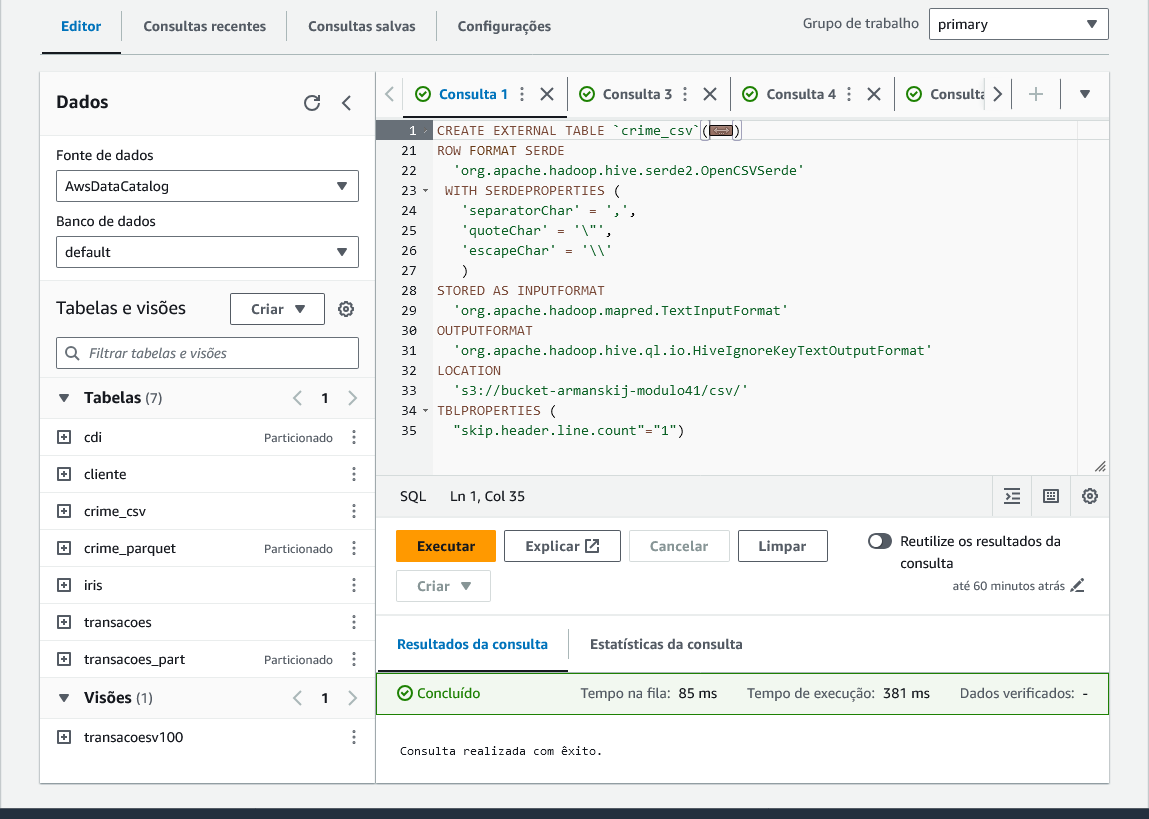

In [50]:
Image(filename ='/content/tabela_csv.png' )

 - **Parquet**

Vamos criar os recursos na AWS:

1. Tabela no `AWS Athena` apontando para os arquivos e suas partições.
1. Carregar as partições.

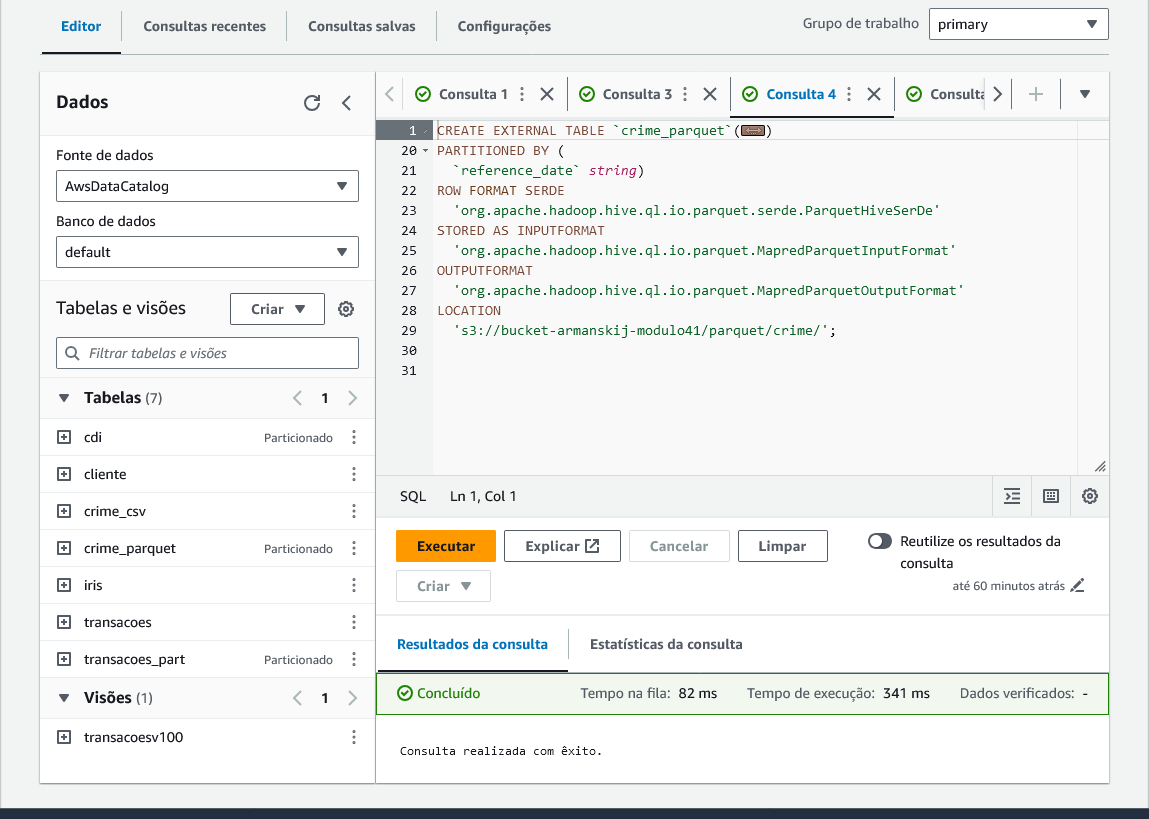

In [52]:
Image(filename = '/content/tabela_parquet.png')

Por fim, vamos executar um conjunto de consultas SQL em ambas as tabelas e observar a quantidade de dados escaneados.

 - Efeito da **orientação a coluna**:

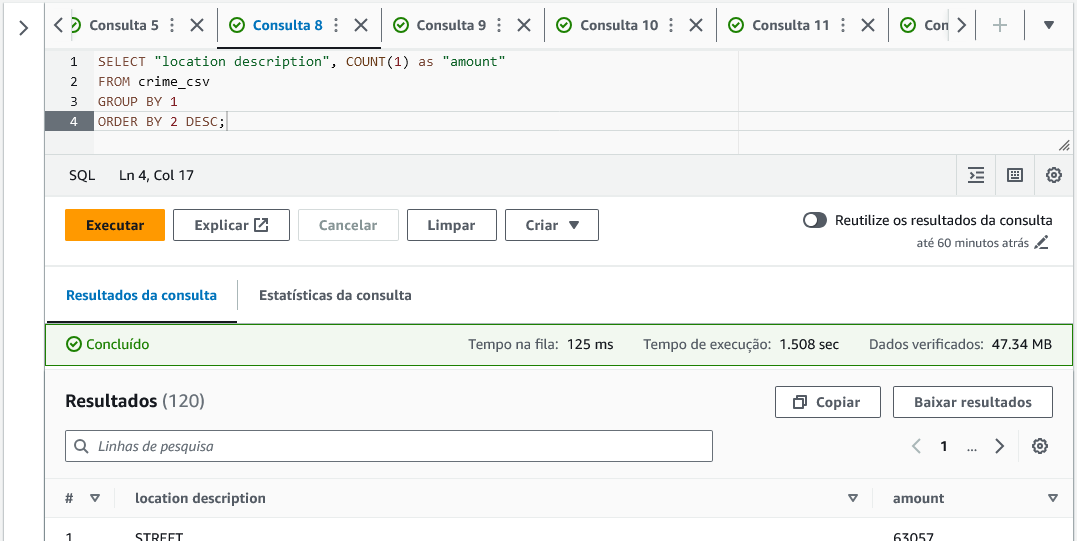

In [53]:
Image(filename = '/content/query1_csv.png')

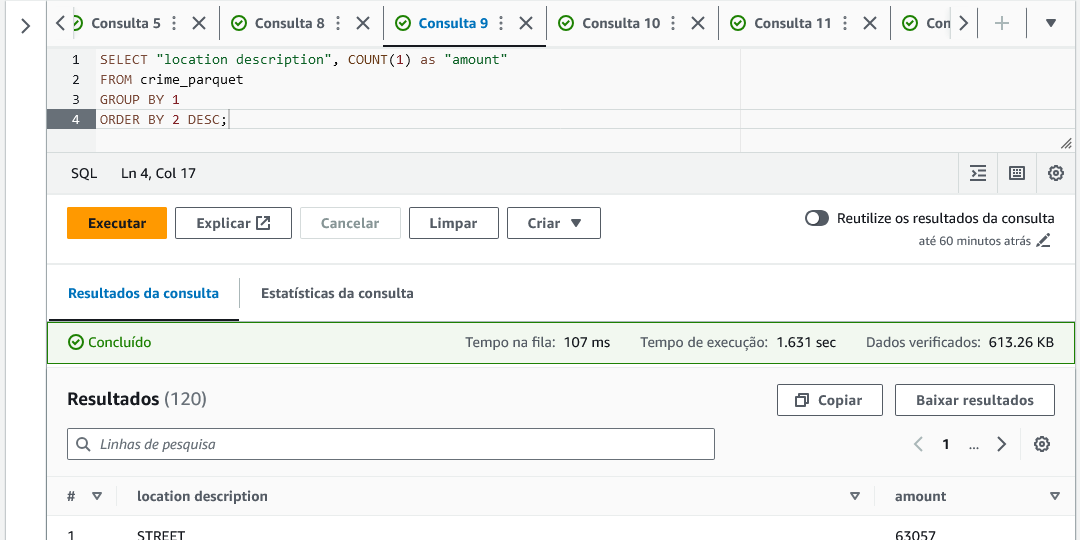

In [54]:
Image(filename='/content/query1_parquet.png')

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 0.44 MB. Ou seja, a tabela com o dado **orientado a coluna** escaneou **108 vezes** menos dados para a consulta SQL que seu par em `csv`.

 - Efeito do **particionamento**:

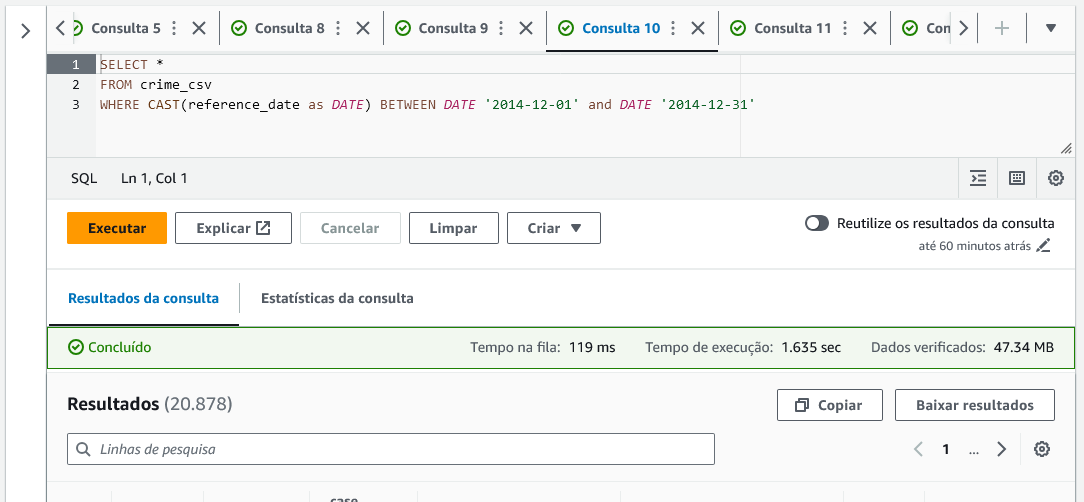

In [55]:
Image(filename='/content/query2_csv.png')

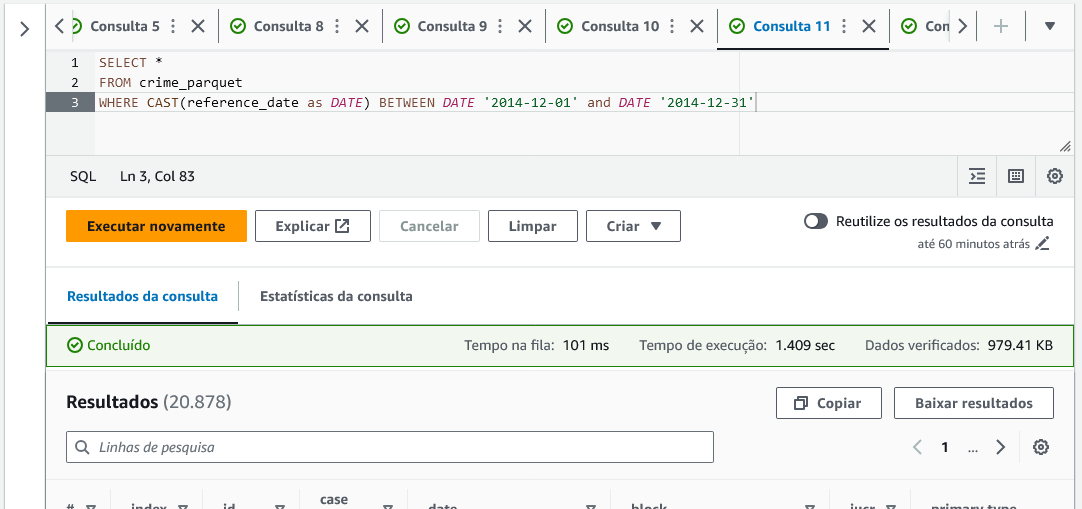

In [56]:
Image(filename='/content/query2_parquet.png')

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabeka `crime_parquet`, a consulta escaneou 1.00 MB. Ou seja, a tabela com o dado **particionado** escaneou **47.34 vezes** menos dados para a consulta SQL que seu par em `csv`.

 - Efeito da **orientação a coluna** e do **particionamento**:

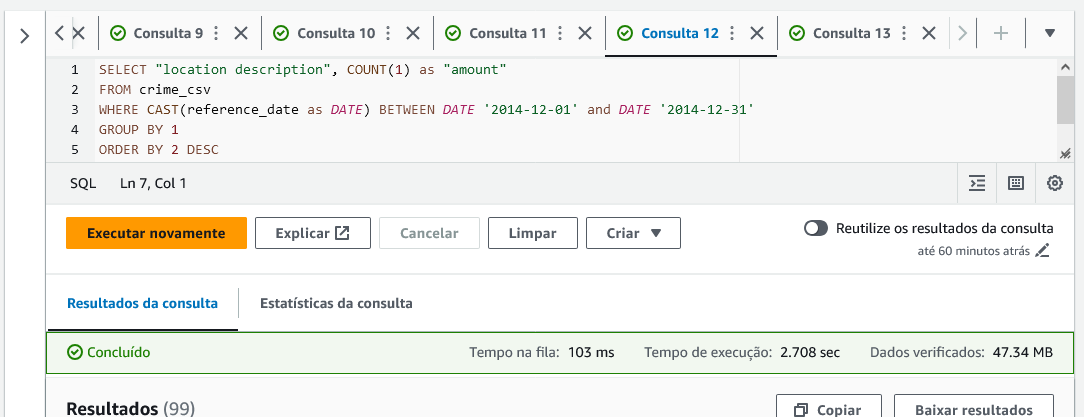

In [57]:
Image(filename='/content/query3_csv.png')

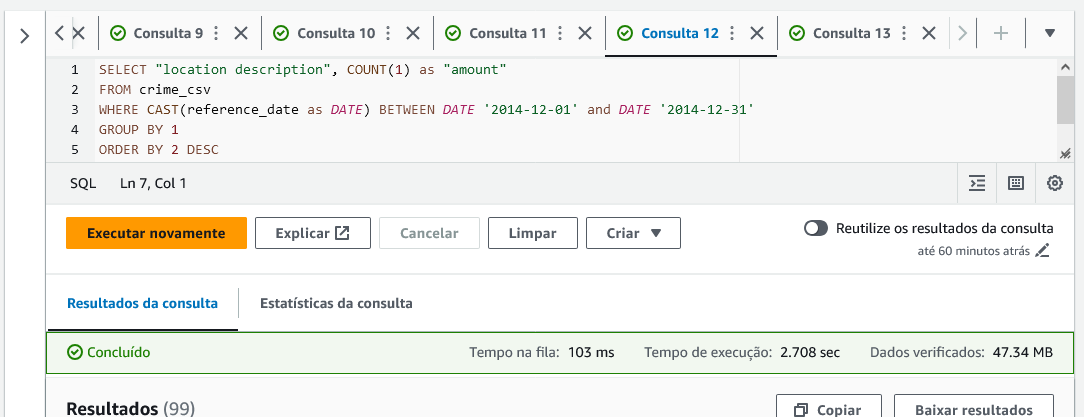

In [58]:
Image(filename='/content/query3_csv.png')

A consulta escaneou 47.34 MB para a tabela `crime_csv`, que é o mesmo tamanho do arquivo, logo um *full scan*. Já para a tabela `crime_parquet`, a consulta escaneou 0.04 MB. Ou seja, a tabela com o dado **particionado** e **orientado a coluna** escaneou **1183.5 vezes** menos dados para a consulta SQL que seu par em `csv`.